In [2]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 
from keras.models import model_from_json
from skimage.transform import resize
import matplotlib.image as image
from skimage import color
from time import time
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import math

In [13]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename,verbose=False): 
    if verbose:
        print(f'Loading file: {filename} ...')
    dcm = pydicom.dcmread(filename)
    
    if verbose:
        print(dcm)
        print(f'ID: {dcm.PatientID}')
        print(f'Sex: {dcm.PatientSex}')
        print(f'Age: {dcm.PatientAge}')
        print(f'Modality: {dcm.Modality}')
        print(f'Study Description: {dcm.StudyDescription}')
        print(f'Rows: {dcm.Rows}')
        print(f'Columns: {dcm.Columns}')
        
    # Age --- 
    age = int(dcm.PatientAge)
    if age<2 or age>90:
        print(f'Image {filename} rejected, Age: {age}')
        return None
    
    # Body Part - 
    body_part = dcm.BodyPartExamined
    if body_part not in ['CHEST','chest','Chest']:
        print(f'Image {filename} rejected, Body Part: {body_part}')
        return None
    
    # Patient Position
    pos = dcm.PatientPosition
    if pos not in ['PA', 'AP']:
        print(f'Image {filename} rejected, Patient position: {pos}')
        return None
    
    # Modali
    mod = dcm.Modality                            
    if mod != 'DX':
        print(f'Image {filename} rejected, Modality: {mod}')
        return None
    
    
    return dcm.pixel_array
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size,verbose=False): 
    
    if verbose:
        print(f'Image Data: {img.shape}')
    
    if len(img.shape) ==3:
        img = color.rgb2gray(img)
    
    resized_img = resize(img,(img_size[1],img_size[2]),anti_aliasing=False)
    
    if verbose:
        print(f'Resized Data: {resized_img.shape}')
        
    proc_img = resized_img.reshape((1,img_size[1],img_size[2],1))
    proc_img = np.repeat(proc_img,img_size[3],axis=3)
    
    return proc_img    
        

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    json_file = open(model_path,'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    
    model.load_weights(weight_path)
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    
    pred = model.predict(img)
    prediction = pred>thresh
    return prediction[0][0]
    
    return prediction 

def show_image_distr(img):
    f = plt.figure()
    f.set_figwidth(10)
    f.add_subplot(1, 2, 1)
    plt.imshow(img)
    f.add_subplot(1, 2, 2)
    plt.hist(img.flatten(), bins=256)
    plt.show()

Loading file: test1.dcm ...
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROM

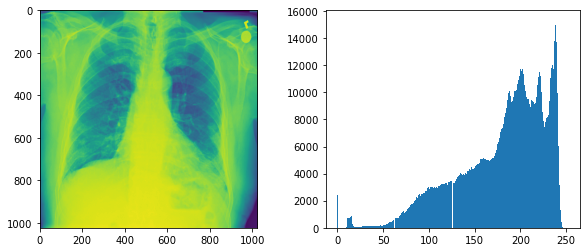

In [6]:
img_example = check_dicom('test1.dcm',verbose=True)
show_image_distr(img_example)

Image Data: (1024, 1024)
Resized Data: (224, 224)


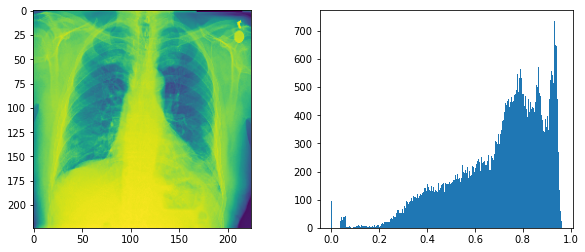

In [7]:
img_example_proc = preprocess_image(img_example, -1, -1, (1, 224, 224, 3), verbose=True)[0, :, :, 0]
show_image_distr(img_example_proc)

In [22]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'my_model.json'
weight_path = 'xray_class_model.best.hdf5'

IMG_SIZE=(1,224,224,3)
img_mean = -1
img_std = -1

my_model = load_model(model_path, weight_path) #loads model
thresh = 0.4

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print(pred)
    
def predict_dicom(filename):
    img = np.array([])
    img = check_dicom(filename)
    
    if img is None:
        return None
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    return pred

False
True
True
Image test4.dcm rejected, Body Part: RIBCAGE
Image test5.dcm rejected, Modality: CT
Image test6.dcm rejected, Patient position: XX


In [15]:
def show_image_pred(img, filename, pred):
    plt.imshow(img, cmap='gray')
    plt.title(f'{filename}, prediction: {pred}')
    plt.show()

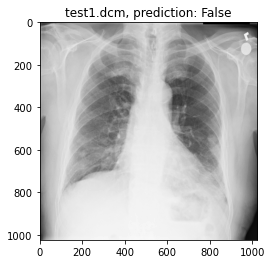

In [23]:
img_example_pred = predict_dicom('test1.dcm')
show_image_pred(img_example, 'test1.dcm', img_example_pred)

Image test4.dcm rejected, Body Part: RIBCAGE
Image test5.dcm rejected, Modality: CT
Image test6.dcm rejected, Patient position: XX


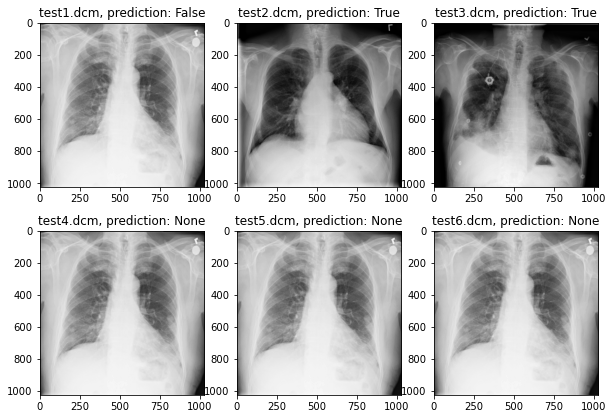

In [24]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)

for i,filename in enumerate(test_dicoms):
    pred = predict_dicom(filename)
    
    img = pydicom.dcmread(filename).pixel_array        
    
    s = f.add_subplot(2, 3, i+1)
    s.set_title(f'{filename}, prediction: {pred}')
    plt.imshow(img, cmap='gray')

plt.show()

In [26]:
pd.read_csv('pneumonia_valid.csv')

FileNotFoundError: [Errno 2] File pneumonia_valid.csv does not exist: 'pneumonia_valid.csv'